In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# importing the initial model I am going to use
# will be adding more models later on in the notebook!
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
# need statistical analysis tools
from scipy import stats
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
# importing some evaluation metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.model_selection import cross_val_score
# adding in some regularization tools
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV, RidgeCV
# feature selection tools
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV
# pipelines -- ambitious goal
from sklearn.pipeline import Pipeline

In [2]:
# Importing the car price data
data = pd.read_csv('car_price_data.csv')
print(data.shape)
data.head()

(205, 26)


,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


Some of these variables will need to be encoded. I am going to use `pd.get_dummies` for that.

In [3]:
data['CarName'].value_counts()

toyota corona          6
toyota corolla         6
peugeot 504            6
subaru dl              4
honda civic            3
                      ..
jaguar xf              1
dodge challenger se    1
porsche macan          1
audi 5000s (diesel)    1
honda accord cvcc      1
Name: CarName, Length: 147, dtype: int64

I am noticing that the car's MAKE always comes before the first space in the `CarName` variable. I can possibly use a Regex function to capture just the car's MAKE.

In [4]:
# Importing Regex
import re

In [3]:
make_list = data['CarName'].to_list()

In [4]:
make_list[0:5]

['alfa-romero giulia',
 'alfa-romero stelvio',
 'alfa-romero Quadrifoglio',
 'audi 100 ls',
 'audi 100ls']

Regex was actually not necessary. I used the `.partition()` method.

In [5]:
companies = []
for name in make_list:
    companies.append(name.partition(' ')[0])
print(companies[0:10])

['alfa-romero', 'alfa-romero', 'alfa-romero', 'audi', 'audi', 'audi', 'audi', 'audi', 'audi', 'audi']


In [6]:
companies_set = set(companies)
len(companies_set)

28

In [7]:
companies_set

{'Nissan',
 'alfa-romero',
 'audi',
 'bmw',
 'buick',
 'chevrolet',
 'dodge',
 'honda',
 'isuzu',
 'jaguar',
 'maxda',
 'mazda',
 'mercury',
 'mitsubishi',
 'nissan',
 'peugeot',
 'plymouth',
 'porcshce',
 'porsche',
 'renault',
 'saab',
 'subaru',
 'toyota',
 'toyouta',
 'vokswagen',
 'volkswagen',
 'volvo',
 'vw'}

There are some issues with the make names and also some duplicates. Will need to use a conditional statement to fix the ones that are spelt wrong or duplicated.  
  
Since there aren't too many I can just do this by hand. But I will still write a function so I can correct any of the entries in my data with incorrect MAKE names.

In [8]:
# First I am going to lowercase all of the CarNames in the original data
companies_lower = [x.lower() for x in companies]

In [9]:
data.insert(2,'make',companies)

In [41]:
data.head()

,car_ID,symboling,make,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [10]:
data.drop(columns=['CarName'], axis=1, inplace=True)

In [11]:
# Replacing those with easily fixed names. Volkswagen is another issue.
data.replace({'maxda': 'mazda', 'porcshce': 'porsche', 'toyouta':'toyota'}, inplace=True)


In [12]:
data.replace({'vw':'volkswagen', 'vokswagen':'volkswagen'}, inplace=True)


In [16]:
data.make.value_counts()

toyota         32
nissan         17
mazda          17
mitsubishi     13
honda          13
subaru         12
volkswagen     12
peugeot        11
volvo          11
dodge           9
buick           8
bmw             8
plymouth        7
audi            7
saab            6
porsche         5
isuzu           4
chevrolet       3
alfa-romero     3
jaguar          3
renault         2
mercury         1
Nissan          1
Name: make, dtype: int64

In [13]:
# Nissan slipped through somehow
data.replace('Nissan', 'nissan', inplace=True)

In [18]:
data.make.value_counts()

toyota         32
nissan         18
mazda          17
mitsubishi     13
honda          13
subaru         12
volkswagen     12
peugeot        11
volvo          11
dodge           9
buick           8
bmw             8
plymouth        7
audi            7
saab            6
porsche         5
isuzu           4
chevrolet       3
alfa-romero     3
jaguar          3
renault         2
mercury         1
Name: make, dtype: int64

Now our data has only make and we can start comparing companies as part of our EDA

In [19]:
data.head()

,car_ID,symboling,make,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


Thinking... can also do some sort of clustering techniques here. Cluster the cars into categories based on whatever the computer finds.  
  
Time to start formatting the data for linear regression techniques.

In [14]:
data.drop(columns=['car_ID'], axis=1, inplace=True)

In [15]:
data.symboling.value_counts()

 0    67
 1    54
 2    32
 3    27
-1    22
-2     3
Name: symboling, dtype: int64

Now to visualize data distributions.

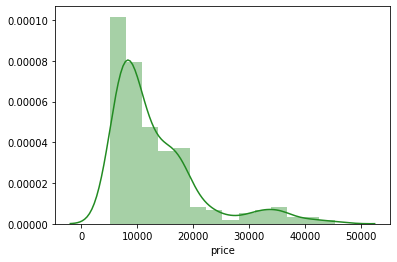

In [16]:
sns.distplot(data['price'], color='forestgreen')

In [17]:
pd.DataFrame(data.groupby('make')['price'].value_counts()).T

make  alfa-romero                audi                                          \
price   16500.000 13495.000 13950.000 15250.000 17450.000 17710.000 17859.167   
price           2         1         1         1         1         1         1   

make                            bmw                                          \
price 18920.000 23875.000 16430.000 16925.000 20970.000 21105.000 24565.000   
price         1         1         1         1         1         1         1   

make                                    buick                                \
price 30760.000 36880.000 41315.000 25552.000 28176.000 28248.000 31600.000   
price         1         1         1         1         1         1         1   

make                                          chevrolet                      \
price 34184.000 35056.000 40960.000 45400.000 5151.000  6295.000  6575.000    
price         1         1         1         1         1         1         1   

make      dodge                                                              \
price 5572.000  6229.000  6377.000  6692.000  7609.000  7957.000  8558.000    
price         1         1         1         1         1         1         1   

make                          honda                                          \
price 8921.000  12964.000 7295.000  5399.000  6479.000  6529.000  6855.000    
price         1         1         2         1         1         1         1   

make                                                                         \
price 7129.000  7895.000  8845.000  9095.000  10295.000 10345.000 12945.000   
price         1         1         1         1         1         1         1   

make      isuzu                        jaguar                         mazda  \
price 8916.500  6785.000  11048.000 32250.000 35550.000 36000.000 5195.000    
price         2         1         1         1         1         1         1   

make                                                                         \
price 6095.000  6695.000  6795.000  7395.000  8495.000  8845.000  10245.000   
price         1         1         1         1         1         1         1   

make                                                                         \
price 10595.000 10795.000 10945.000 11245.000 11845.000 13645.000 15645.000   
price         1         1         1         1         1         1         1   

make                        mercury mitsubishi                                \
price 18280.000 18344.000 16503.000  9279.000  5389.000  6189.000  6669.000    
price         1         1         1          2         1         1         1   

make                                                                         \
price 6989.000  7689.000  8189.000  8499.000  9959.000  12629.000 14489.000   
price         1         1         1         1         1         1         1   

make               nissan                                                    \
price 14869.000 13499.000 5499.000  6649.000  6849.000  7099.000  7299.000    
price         1         2         1         1         1         1         1   

make                                                                         \
price 7349.000  7499.000  7799.000  7999.000  8249.000  8949.000  9549.000    
price         1         1         1         1         1         1         1   

make                                            peugeot                      \
price 14399.000 17199.000 18399.000 19699.000 11900.000 12440.000 13200.000   
price         1         1         1         1         1         1         1   

make                                                                         \
price 13860.000 15580.000 16630.000 16695.000 16900.000 17075.000 17950.000   
price         1         1         1         1         1         1         1   

make             plymouth                                                    \
price 18150.000 5572.000  6229.000  6692.000  7609.000  7957.000  8921.000    
price         1         1

In [ ]:
# sns.pairplot(data)

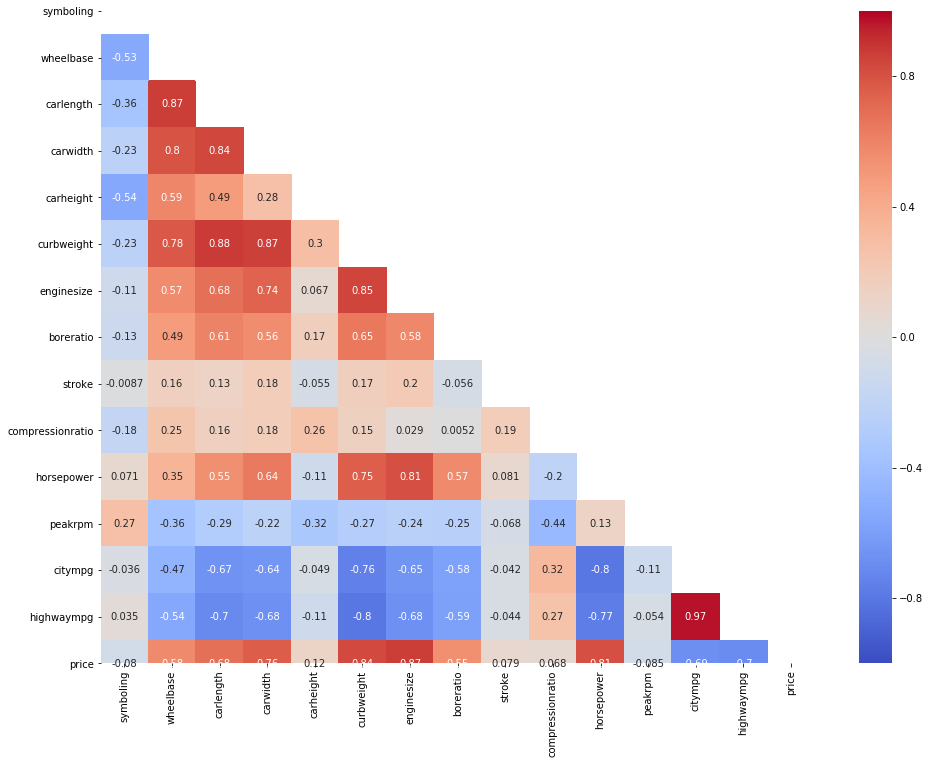

In [25]:
# Looking for multicollinearity
f, ax = plt.subplots(figsize=(16, 12))
matrix = np.triu(data.corr())
sns.heatmap(data.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask = matrix)

In [18]:
data.drop(columns=['symboling'], axis=1, inplace=True)

There are a lot of related features here. I want to reduce this, so I might start to engineer features that are combinations of these features.

In [27]:
data.head()

,make,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [28]:
data.enginelocation.value_counts()

front    202
rear       3
Name: enginelocation, dtype: int64

In [19]:
# Going to start cleaning up the data
make_d = pd.get_dummies(data['make'], prefix='make', drop_first=True)
body = pd.get_dummies(data['carbody'], prefix='body', drop_first=True)
cyl = pd.get_dummies(data['cylindernumber'], prefix='cyl', drop_first=True)
fs = pd.get_dummies(data['fuelsystem'], prefix='fs', drop_first=True)
et = pd.get_dummies(data['enginetype'], prefix='et', drop_first=True)
data['fueltype'] = data.fueltype.map({'gas':0, 'diesel':1})
data['aspiration'] = data.aspiration.map({'std':0, 'turbo':1})
data['doornumber'] = data.doornumber.map({'four':0, 'two':1})
dt = pd.get_dummies(data['drivewheel'], prefix='dt', drop_first=True)
data['enginelocation'] = data.enginelocation.map({'front':0, 'rear':1})

In [20]:
# Let's review these changes
print(data.shape)
data.head()

(205, 24)


,make,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,alfa-romero,0,0,1,convertible,rwd,0,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,alfa-romero,0,0,1,convertible,rwd,0,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,alfa-romero,0,0,1,hatchback,rwd,0,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,audi,0,0,0,sedan,fwd,0,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,audi,0,0,0,sedan,4wd,0,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [21]:
# Now need to remove the columns I dummied and insert them into the data frame
data.drop(columns=['make', 'carbody', 'cylindernumber', 'fuelsystem', 'enginetype',
                  'drivewheel'], axis=1, inplace=True)
# And re-insert the dummied variables
data = pd.concat([data, make_d, body, cyl, fs, et, dt], axis=1)

In [22]:
print(data.shape)
data.head()

(205, 64)


,fueltype,aspiration,doornumber,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,make_audi,make_bmw,make_buick,make_chevrolet,make_dodge,make_honda,make_isuzu,make_jaguar,make_mazda,make_mercury,make_mitsubishi,make_nissan,make_peugeot,make_plymouth,make_porsche,make_renault,make_saab,make_subaru,make_toyota,make_volkswagen,make_volvo,body_hardtop,body_hatchback,body_sedan,body_wagon,cyl_five,cyl_four,cyl_six,cyl_three,cyl_twelve,cyl_two,fs_2bbl,fs_4bbl,fs_idi,fs_mfi,fs_mpfi,fs_spdi,fs_spfi,et_dohcv,et_l,et_ohc,et_ohcf,et_ohcv,et_rotor,dt_fwd,dt_rwd
0,0,0,1,0,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
3,0,0,0,0,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30,13950.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
4,0,0,0,0,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22,17450.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0


Has increased the dimensionality by 40. Not bad. Will be dropping columns along the way after using Feature Selection tools. 


In [23]:
# After reviewing the heat matrix, there is some multicollinearity I need to deal with
# Going to drop a couple columns and re-run the heat matrix
copy = data.copy()
copy.drop(columns=['carlength', 'carwidth'], axis=1, inplace=True)


In [24]:
def heat_matrix(data):
    f, ax = plt.subplots(figsize=(16, 12))
    matrix = np.triu(data.corr())
    sns.heatmap(data.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask = matrix)

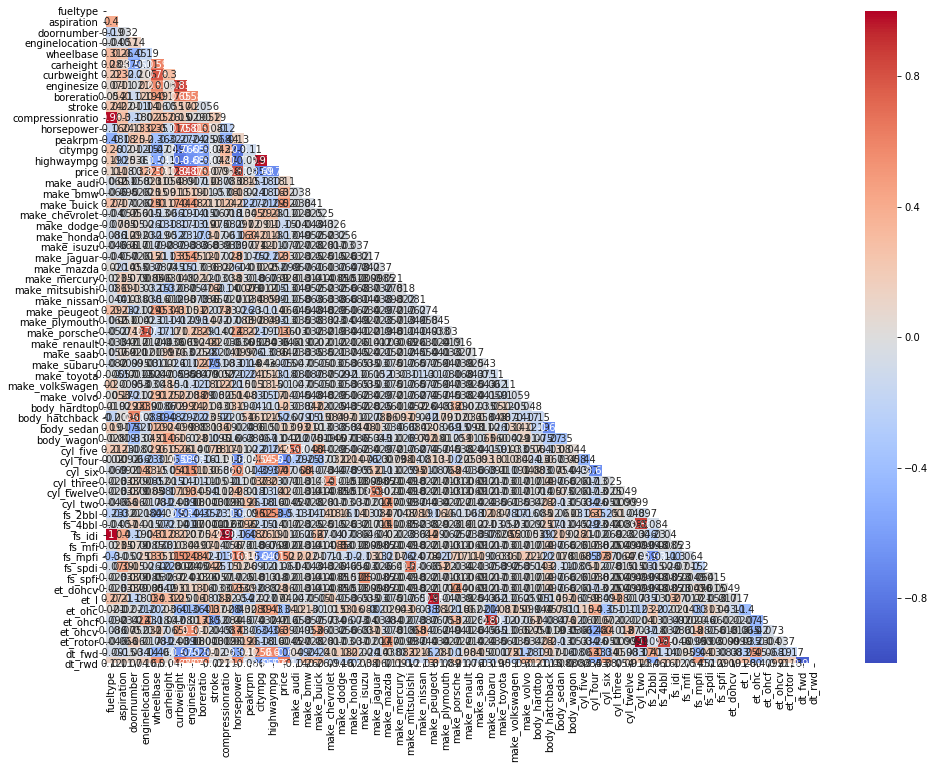

In [35]:
heat_matrix(copy)

That isn't very telling. There are still some hot spots left, I need to reduce dimensionality. I am going to run some baseline models with the data and see what I can do from there.

In [25]:
lr = LinearRegression()
X = copy.drop(columns=['price'], axis=1)
y = copy.price
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.3)
print('Training Set Dimensions', X_train.shape, y_train.shape)
print('Test Set Dimensions', X_test.shape, y_test.shape)

Training Set Dimensions (143, 61) (143,)
Test Set Dimensions (62, 61) (62,)


In [26]:
# Fitting model
lr.fit(X_train,y_train)
# Getting the R^2 score
print('R^2 Score of Baseline Model: ', lr.score(X_train,y_train))


R^2 Score of Baseline Model:  0.9755235680585965


Looks like we have some severe overfitting. Let's look at the test data.

RMSE : 2623.1668643774733


Text(0, 0.5, 'Predictions')

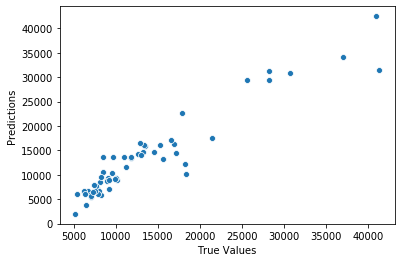

In [27]:
# Making a prediction using the test data
y_pred = lr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('RMSE :', rmse)
sns.scatterplot(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [28]:
# R^2 of the test data
lr.score(X_test,y_test)

0.9006846198769555

In [29]:
# Using OLS to create a model and return some metrics
outcome = 'price'
predictors = copy.drop('price', axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum
model = ols(formula=formula, data=copy).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     66.47
Date:                Thu, 18 Jun 2020   Prob (F-statistic):           1.76e-81
Time:                        15:14:12   Log-Likelihood:                -1795.5
No. Observations:                 205   AIC:                             3707.
Df Residuals:                     147   BIC:                             3900.
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         -1.14e+04   1.09e+04     -1.046      0.297   -3.29e+04    1.01e+04
fueltype          5306.5380   3393.127      1.564      0.120   -1399.074     1.2e+04
aspiration        2143.9298    830.526      2.581      0.011     502.616    3785.243
doornumber        -292.6663    472.123     -0.620      0.536   -1225.692     640.360
enginelocation    5503.5778   1887.201      2.916      0.004    1774.029    9233.127
wheelbase          237.4611     72.743      3.264      0.001      93.705     381.217
carheight         -282.9765    135.461     -2.089      0.038    -550.680     -15.273
curbweight           5.3582      1.491      3.594      0.000       2.412       8.304
enginesize          87.8576     25.588      3.434      0.001      37.290     138.425
boreratio        -3140.2216   1903.439     -1.650      0.101   -6901.861     621.418
stroke           -1255.4631   1024.676     -1.225      0.222   -3280.462     769.536
compressionratio  -709.8817    500.127     -1.419      0.158   -1698.249     278.486
horsepower          11.3702     24.298      0.468      0.641     -36.649      59.389
peakrpm              2.3772      0.670      3.549      0.001       1.054       3.701
citympg             48.2919    138.209      0.349      0.727    -224.842     321.426
highwaympg         114.8009    118.856      0.966      0.336    -120.087     349.689
make_audi          822.1444   2246.336      0.366      0.715   -3617.140    5261.429
make_bmw          5180.0761   2410.410      2.149      0.033     416.543    9943.609
make_buick        3537.9544   2533.198      1.397      0.165   -1468.236    8544.145
make_chevrolet   -4860.4187   2267.620     -2.143      0.034   -9341.765    -379.072
make_dodge       -5117.6248   1836.447     -2.787      0.006   -8746.872   -1488.378
make_honda       -2159.2019   2224.446     -0.971      0.333   -6555.227    2236.823
make_isuzu       -3257.3351   2040.447     -1.596      0.113   -7289.734     775.064
make_jaguar         99.8274   2701.714      0.037      0.971   -5239.390    5439.045
make_mazda       -2046.1681   1742.186     -1.174      0.242   -5489.134    1396.798
make_mercury     -2902.3237   3020.251     -0.961      0.338   -8871.044    3066.397
make_mitsubishi  -5703.8156   1857.185     -3.071      0.003   -9374.046   -2033.585
make_nissan      -3256.8575   1723.805     -1.889      0.061   -6663.498     149.783
make_peugeot     -3007.0419   1839.448     -1.635      0.104   -6642.220     628.136
make_plymouth    -5454.1460   1850.598     -2.947      0.004   -9111.360   -1796.932
make_porsche      5528.4678   2927.979      1.888      0.061    -257.902    1.13e+04
make_renault     -3469.8404   2294.716     -1.512      0.133   -8004.735    1065.054
make_saab          118.9469   2028.142      0.059      0.953   -3889.135    4127.029
make_subaru      -3190.

In [30]:
# From this analysis I have chosen all variables with p-value < 0.05
variables = ['aspiration', 'enginelocation', 'wheelbase', 'carheight', 'curbweight',
            'enginesize', 'peakrpm', 'make_bmw', 'make_chevrolet', 'make_dodge',
            'make_mitsubishi', 'make_plymouth', 'make_subaru', 'make_toyota',
            'body_hardtop', 'body_hatchback', 'body_sedan', 'body_wagon', 'et_ohcf']
X_anova = copy[variables]
y_anova = copy.price

In [32]:
# Defining function to plot linear regression models against the test data
# Will also print out the important metrics
def linreg(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.3)
    lr = LinearRegression()
    lr.fit(X_train,y_train)
    print('New R^2 value for training data is: ', lr.score(X_train,y_train))
    y_pred = lr.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    print('Test RMSE: ',rmse)
    # Make a graph showing the performance over the index
    fig,ax=plt.subplots(figsize=(12,8))
    sns.lineplot(x=y_test.reset_index(drop=True).index,y=y_test,color='blue',ax=ax,)
    sns.lineplot(x=y_test.reset_index(drop=True).index,y=y_pred,color='grey',ax=ax)
    plt.xlabel('INDEX')
    plt.ylabel('PRICE')
    plt.title('COMPARISON OF MODEL TO ACTUAL DATA')
    plt.legend(['TEST DATA','PREDICTION'],loc='best')
    plt.show()

New R^2 value for training data is:  0.9133053844100566
Test RMSE:  3152.6847475252794


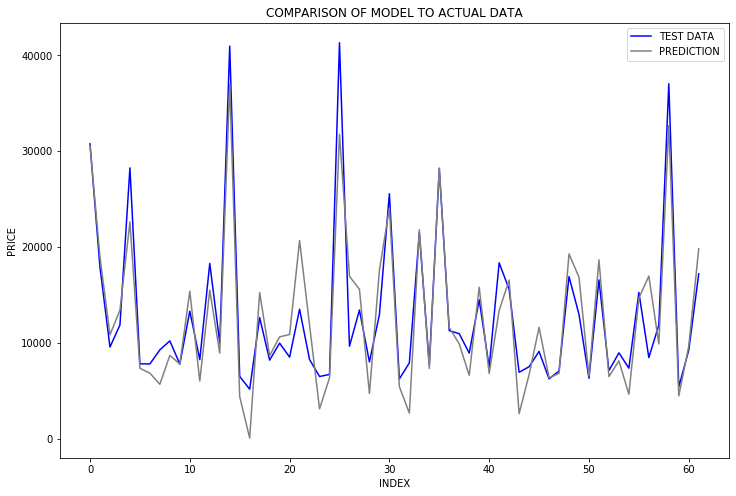

In [33]:
linreg(X_anova,y_anova)

In [34]:
# Using RFE for recursive feature selection
from sklearn.feature_selection import RFE
selector = RFE(lr, n_features_to_select=5)
selector = selector.fit(X, y)

In [35]:
# Making this into a data frame to see which features I should keep
features = pd.DataFrame(selector.ranking_)
features['variables'] = X.columns
features.rename(columns={0:'rank'}, inplace=True)
features.sort_values(by='rank')

,rank,variables
16,1,make_bmw
3,1,enginelocation
53,1,et_dohcv
17,1,make_buick
22,1,make_jaguar
...,...,...
10,53,compressionratio
14,54,highwaympg
13,55,citympg
6,56,curbweight


In [36]:
feats = features[features['rank'] < 15].sort_values(by='rank')['variables'].to_list()

Without standardizing any of this data, I am going to run another model using the top features from above.

New R^2 value for training data is:  0.889594518240189
Test RMSE:  3794.2754058787314


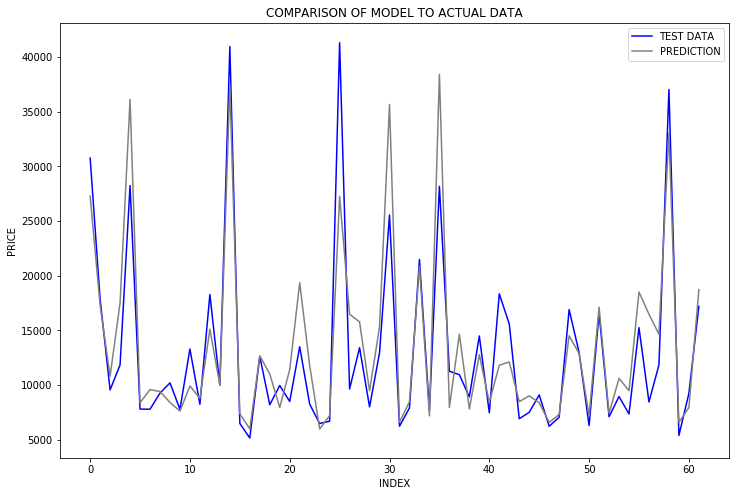

In [37]:
X_rfe = copy[feats]
y_rfe = copy.price
linreg(X_rfe,y_rfe)

In [38]:
# Do I need to standardize anything in my anova data? RFE data?
X_anova.head()

,aspiration,enginelocation,wheelbase,carheight,curbweight,enginesize,peakrpm,make_bmw,make_chevrolet,make_dodge,make_mitsubishi,make_plymouth,make_subaru,make_toyota,body_hardtop,body_hatchback,body_sedan,body_wagon,et_ohcf
0,0,0,88.6,48.8,2548,130,5000,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,88.6,48.8,2548,130,5000,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,94.5,52.4,2823,152,5000,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,99.8,54.3,2337,109,5500,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,99.4,54.3,2824,136,5500,0,0,0,0,0,0,0,0,0,1,0,0


In [39]:
X_rfe.head()

,enginelocation,make_jaguar,make_buick,et_dohcv,make_bmw,boreratio,make_audi,cyl_twelve,cyl_six,make_subaru,make_porsche,make_saab,cyl_five,cyl_two,body_hardtop,body_hatchback,body_wagon,body_sedan
0,0,0,0,0,0,3.47,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,3.47,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,2.68,0,0,1,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,3.19,1,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,3.19,1,0,0,0,0,0,1,0,0,0,0,1


In [40]:
# The RFE data seems to be mostly the categorical variables, whereas the ANOVA data isn't
# Will try out scaler on the ANOVA data
scaler = StandardScaler()
X_anova_sc = scaler.fit_transform(X_anova)
X_anova_sc = pd.DataFrame(X_anova_sc, columns=X_anova.columns)
X_anova_sc.head()

,aspiration,enginelocation,wheelbase,carheight,curbweight,enginesize,peakrpm,make_bmw,make_chevrolet,make_dodge,make_mitsubishi,make_plymouth,make_subaru,make_toyota,body_hardtop,body_hatchback,body_sedan,body_wagon,et_ohcf
0,-0.469295,-0.121867,-1.690772,-2.020417,-0.014566,0.074449,-0.262960,-0.201517,-0.121867,-0.214286,-0.260208,-0.188025,-0.249351,-0.430083,-0.201517,-0.720082,-0.938474,-0.372678,-0.280976
1,-0.469295,-0.121867,-1.690772,-2.020417,-0.014566,0.074449,-0.262960,-0.201517,-0.121867,-0.214286,-0.260208,-0.188025,-0.249351,-0.430083,-0.201517,-0.720082,-0.938474,-0.372678,-0.280976
2,-0.469295,-0.121867,-0.708596,-0.543527,0.514882,0.604046,-0.262960,-0.201517,-0.121867,-0.214286,-0.260208,-0.188025,-0.249351,-0.430083,-0.201517,1.388730,-0.938474,-0.372678,-0.280976
3,-0.469295,-0.121867,0.173698,0.235942,-0.420797,-0.431076,0.787855,-0.201517,-0.121867,-0.214286,-0.260208,-0.188025,-0.249351,-0.430083,-0.201517,-0.720082,1.065559,-0.372678,-0.280976
4,-0.469295,-0.121867,0.107110,0.235942,0.516807,0.218885,0.787855,-0.201517,-0.121867,-0.214286,-0.260208,-0.188025,-0.249351,-0.430083,-0.201517,-0.720082,1.065559,-0.372678,-0.280976


New R^2 value for training data is:  0.9133053844100566
Test RMSE:  3152.684747525305


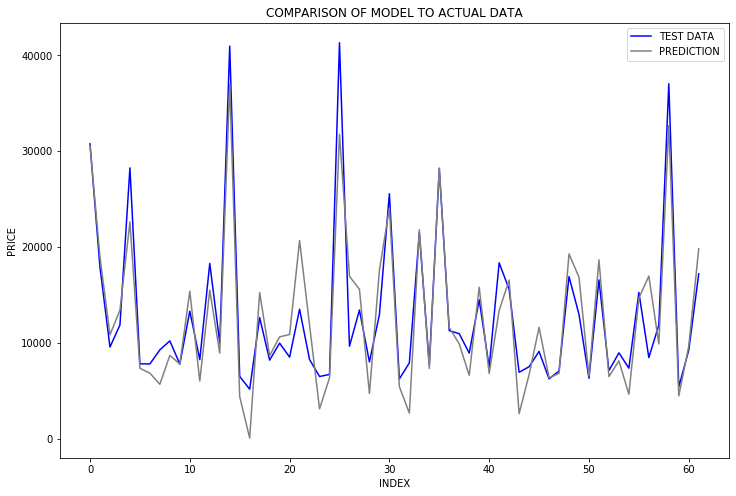

In [41]:
# Let's re-run the linear regression on this transformed data
linreg(X_anova_sc, y_anova)

No change there.

In [42]:
# Going to make a different scaled data frame for the ANOVA
# Only will scale the continuous features with MinMaxScaler
mm = MinMaxScaler()
# Storing the MinMax Scaled dimensions in a separate frame 'cont_anova_data'
cont_anova_data = X_anova[['wheelbase','carheight','curbweight','enginesize','peakrpm']]
cont_anova_data = mm.fit_transform(cont_anova_data)
cont_anova_data = pd.DataFrame(cont_anova_data,columns=['wheelbase_mm','carheight_mm','curbweight_mm',
                                                       'enginesize_mm','peakrpm_mm'])
X_anova_sc2 = X_anova.copy()
X_anova_sc2.drop(columns=['wheelbase', 'carheight', 'curbweight',
                         'enginesize', 'peakrpm'], axis=1, inplace=True)
X_anova_sc2 = pd.concat([X_anova_sc2, cont_anova_data], axis=1)
X_anova_sc2.head()

,aspiration,enginelocation,make_bmw,make_chevrolet,make_dodge,make_mitsubishi,make_plymouth,make_subaru,make_toyota,body_hardtop,body_hatchback,body_sedan,body_wagon,et_ohcf,wheelbase_mm,carheight_mm,curbweight_mm,enginesize_mm,peakrpm_mm
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.058309,0.083333,0.411171,0.260377,0.346939
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.058309,0.083333,0.411171,0.260377,0.346939
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.230321,0.383333,0.517843,0.343396,0.346939
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.384840,0.541667,0.329325,0.181132,0.551020
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.373178,0.541667,0.518231,0.283019,0.551020


New R^2 value for training data is:  0.9132626230262311
Test RMSE:  3146.2735874526684


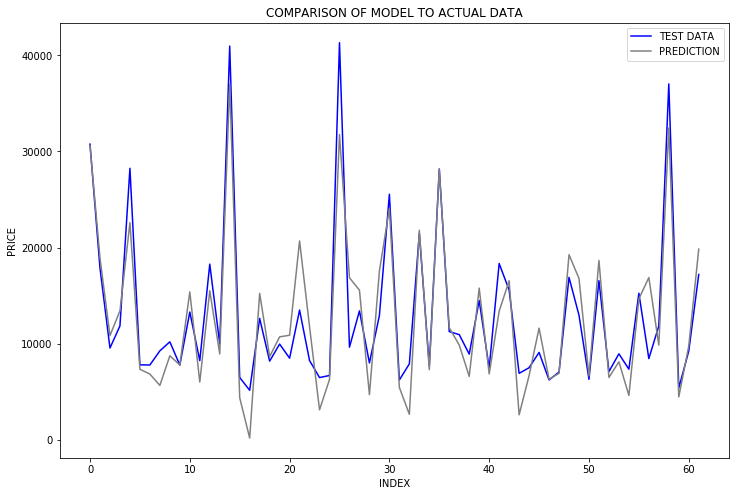

In [43]:
linreg(X_anova_sc2, y_anova)

That helped my RMSE. Nice!

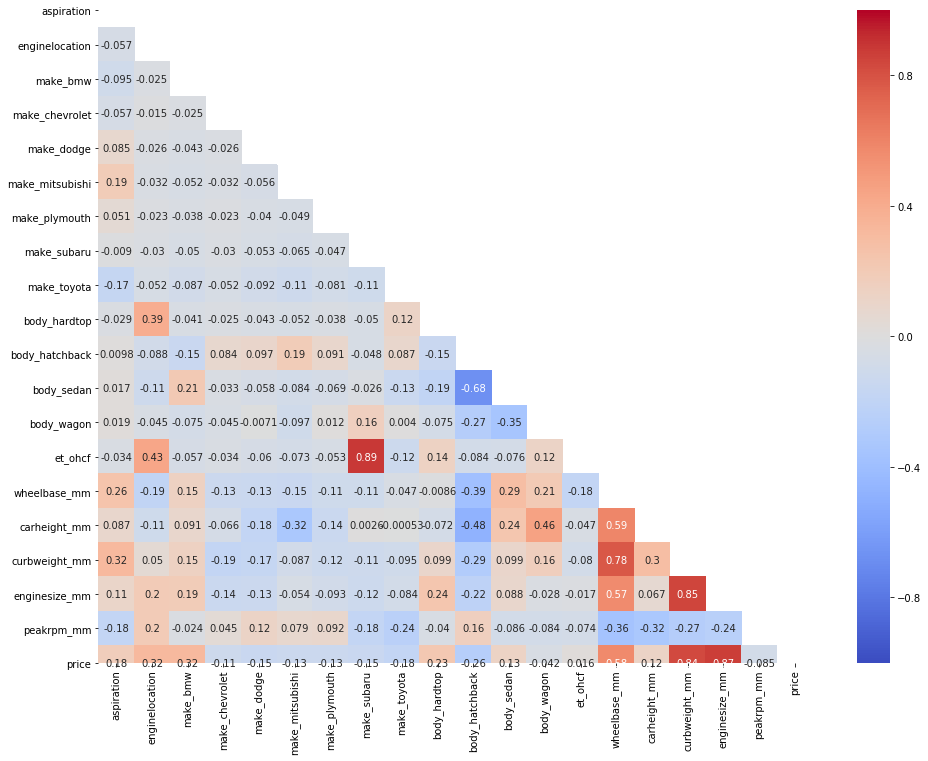

In [44]:
anova_sc2_comparison = pd.concat([X_anova_sc2,y_anova],axis=1)
heat_matrix(anova_sc2_comparison)

In [45]:
# Going to drop 'et_ohcf'
# Going to engineer a new feature 'car_dimensions'
# 'car_dimensions' is simply the average of these columns
X_anova_sc2.drop(columns=['et_ohcf'],axis=1,inplace=True)
car_dimensions = (X_anova_sc2['curbweight_mm']+X_anova_sc2['enginesize_mm']+
                  X_anova_sc2['carheight_mm']+X_anova_sc2['wheelbase_mm'])/4

In [46]:
# Now to drop those columns since I just engineered a feature from them
X_anova_sc2.drop(columns=['curbweight_mm','enginesize_mm','carheight_mm','wheelbase_mm'],axis=1,inplace=True)

In [47]:
# Replace with 'car_dimensions'
X_anova_sc2['car_dimensions'] = car_dimensions

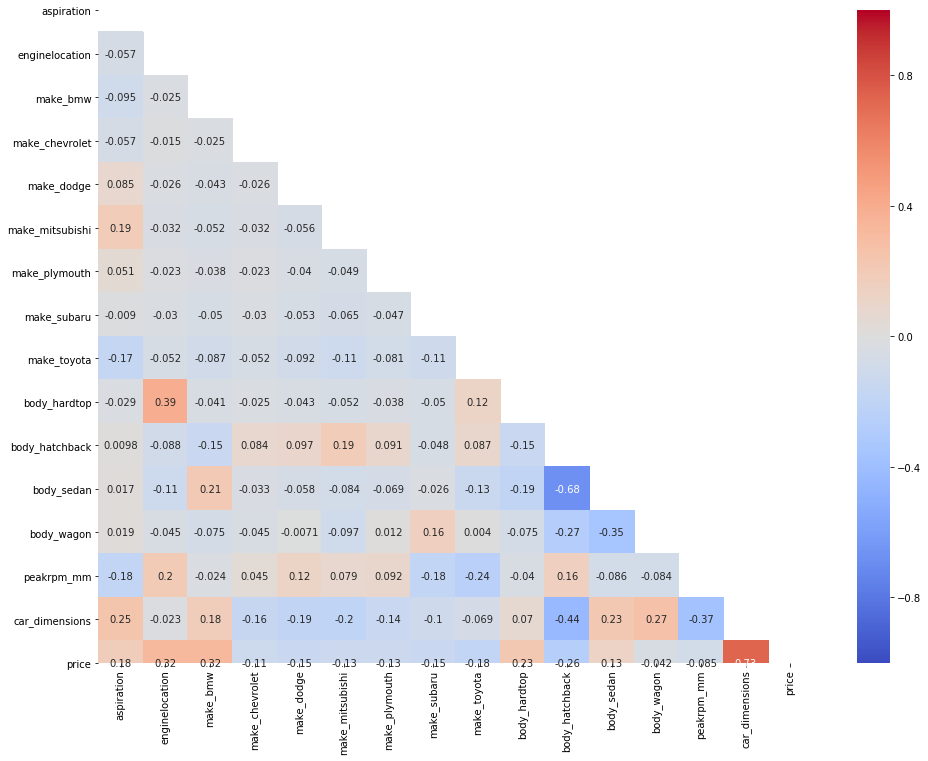

In [48]:
# Run the heat matrix again
anova_sc2_comparison = pd.concat([X_anova_sc2,y_anova],axis=1)
heat_matrix(anova_sc2_comparison)

Much better. Time to remodel.

New R^2 value for training data is:  0.7961863353084174
Test RMSE:  3947.657130588035


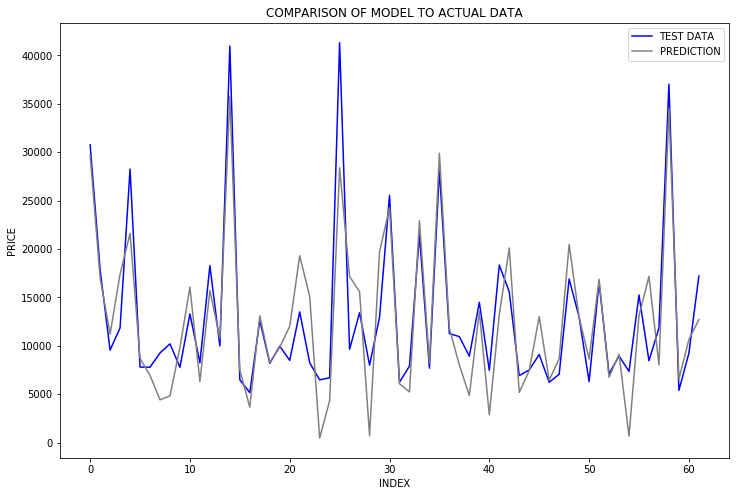

In [49]:
linreg(X_anova_sc2,y_anova)

It seems that my engineered feature decreased model performance.    
  
What would happen if I just got rid of engine_size and curbweight?


In [55]:
X_anova_sc3 = X_anova.copy()
X_anova_sc3.drop(columns=['enginesize','curbweight','wheelbase','carheight', 'peakrpm'], axis=1, inplace=True)
X_anova_sc3.head()

,aspiration,enginelocation,make_bmw,make_chevrolet,make_dodge,make_mitsubishi,make_plymouth,make_subaru,make_toyota,body_hardtop,body_hatchback,body_sedan,body_wagon,et_ohcf
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [58]:
# Now to add in the MinMax scaled dimensions I made before in 'cont_anova_data'
X_anova_sc3 = pd.concat([X_anova_sc3, cont_anova_data], axis=1)
X_anova_sc3.drop(columns=['enginesize_mm','curbweight_mm'],axis=1,inplace=True)
X_anova_sc3.head()

,aspiration,enginelocation,make_bmw,make_chevrolet,make_dodge,make_mitsubishi,make_plymouth,make_subaru,make_toyota,body_hardtop,body_hatchback,body_sedan,body_wagon,et_ohcf,wheelbase_mm,carheight_mm,peakrpm_mm
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.058309,0.083333,0.346939
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.058309,0.083333,0.346939
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.230321,0.383333,0.346939
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.384840,0.541667,0.551020
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.373178,0.541667,0.551020


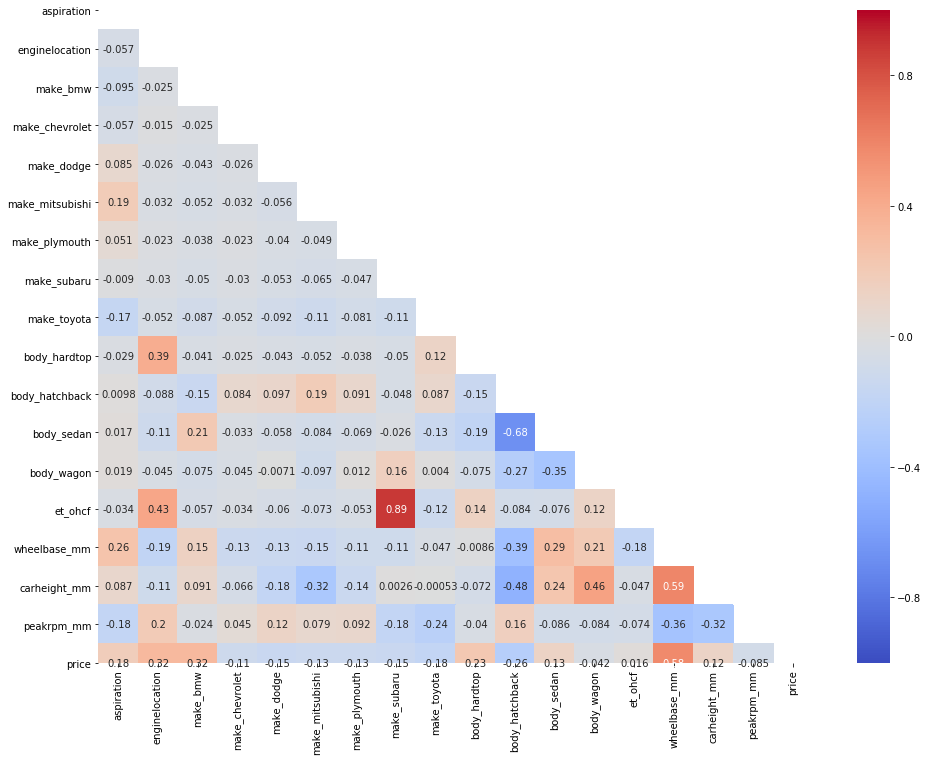

In [59]:
X_anova_sc3_comparison = pd.concat([X_anova_sc3,y_anova],axis=1)
heat_matrix(X_anova_sc3_comparison)

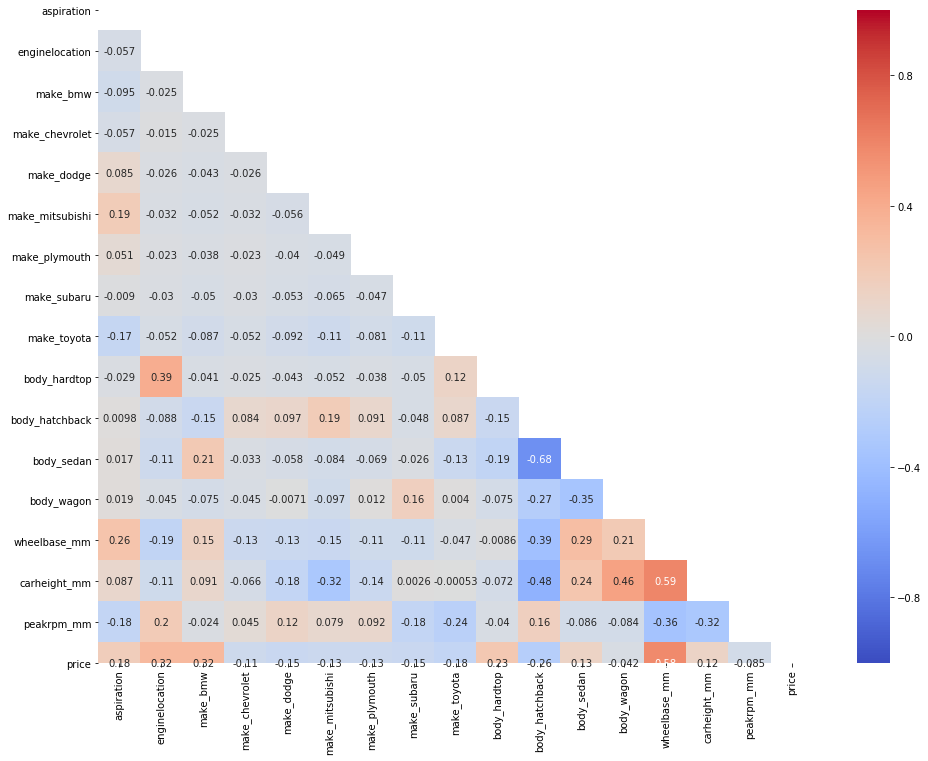

In [60]:
# Still need to drop `et_ohcf`
X_anova_sc3_comparison.drop(columns=['et_ohcf'],axis=1,inplace=True)
heat_matrix(X_anova_sc3_comparison)

In [72]:
# Need to drop et_ohcf
# carheight and wheelbase seem to interact a bit too much
# I am going to try once without combining, once by removing either
# And once by engineering a new feature from them
# Also body_sedan and body_hatchback have a strong negative correlation
## Comenting the below line out as it was already used
# X_anova_sc3.drop(columns=['et_ohcf'],axis=1,inplace=True)
# Frame without height
X_anova_sc3_CH = X_anova_sc3.drop(columns=['carheight_mm'],axis=1)
# Frame without hatchback
X_anova_sc3_WB = X_anova_sc3.drop(columns=['wheelbase_mm'],axis=1)
# Frame without both
X_anova_sc3_none = X_anova_sc3.drop(columns=['carheight_mm','wheelbase_mm'],axis=1)
# Engineered feature
engineered_dimension = (X_anova_sc3['carheight_mm']+X_anova_sc3['wheelbase_mm'])/2
X_anova_sc3_noneEng = X_anova_sc3_none.copy()
X_anova_sc3_noneEng['eng_dimension'] = engineered_dimension


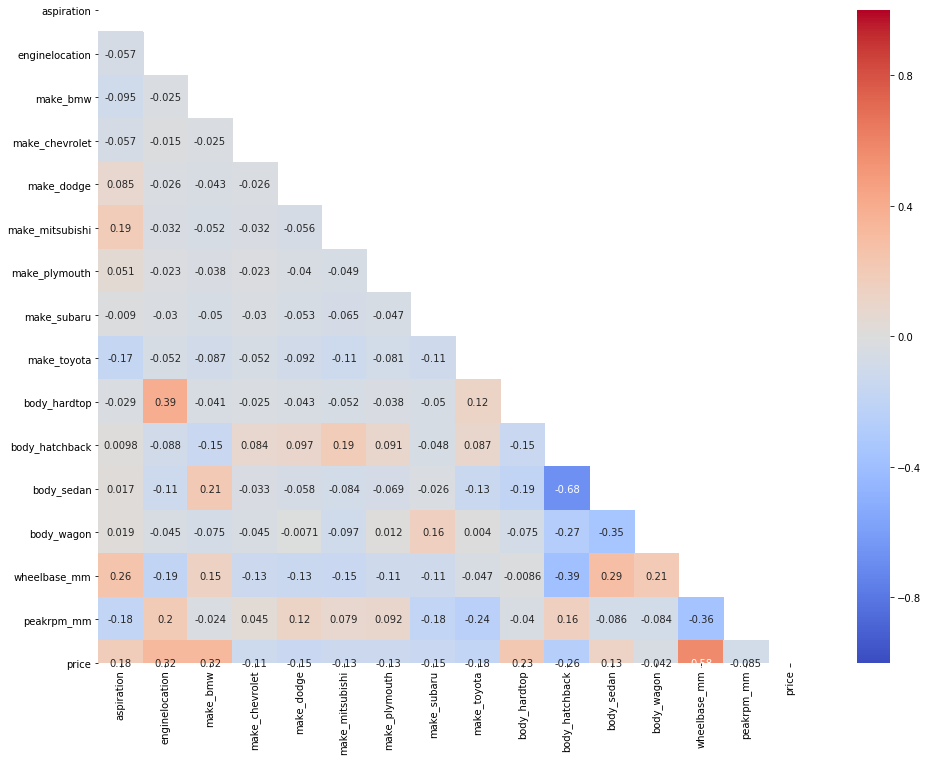

In [76]:
X_anova_sc3_CH_comparison = pd.concat([X_anova_sc3_CH,y_anova],axis=1)
heat_matrix(X_anova_sc3_CH_comparison)

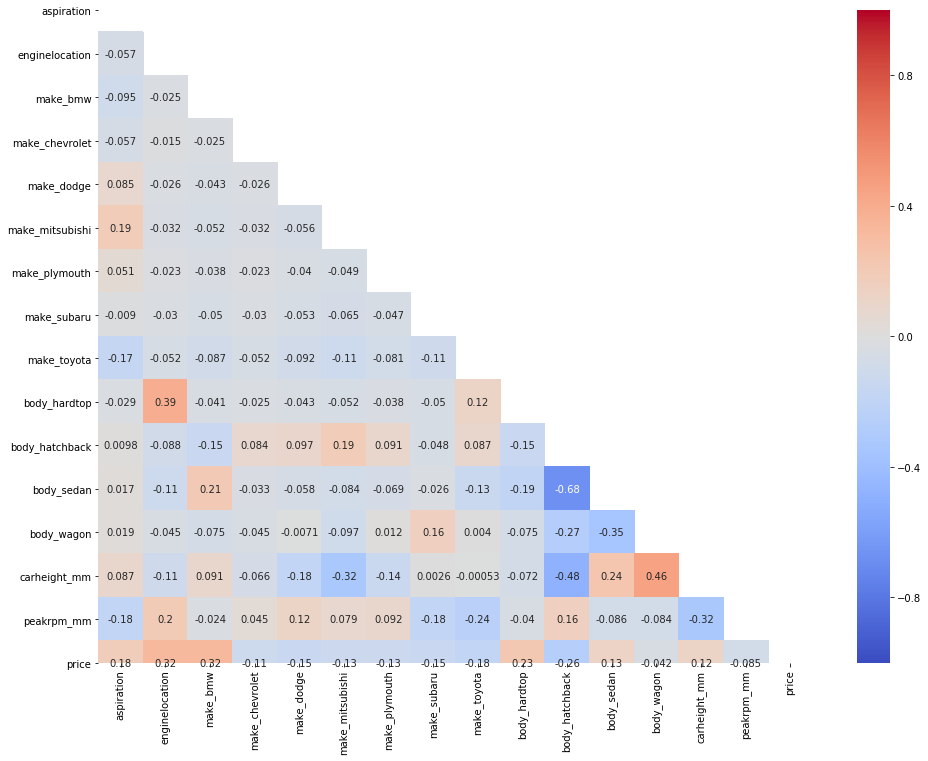

In [77]:
# The above looks good
# Let's keep looking
X_anova_sc3_WB_comparison = pd.concat([X_anova_sc3_WB,y_anova],axis=1)
heat_matrix(X_anova_sc3_WB_comparison)

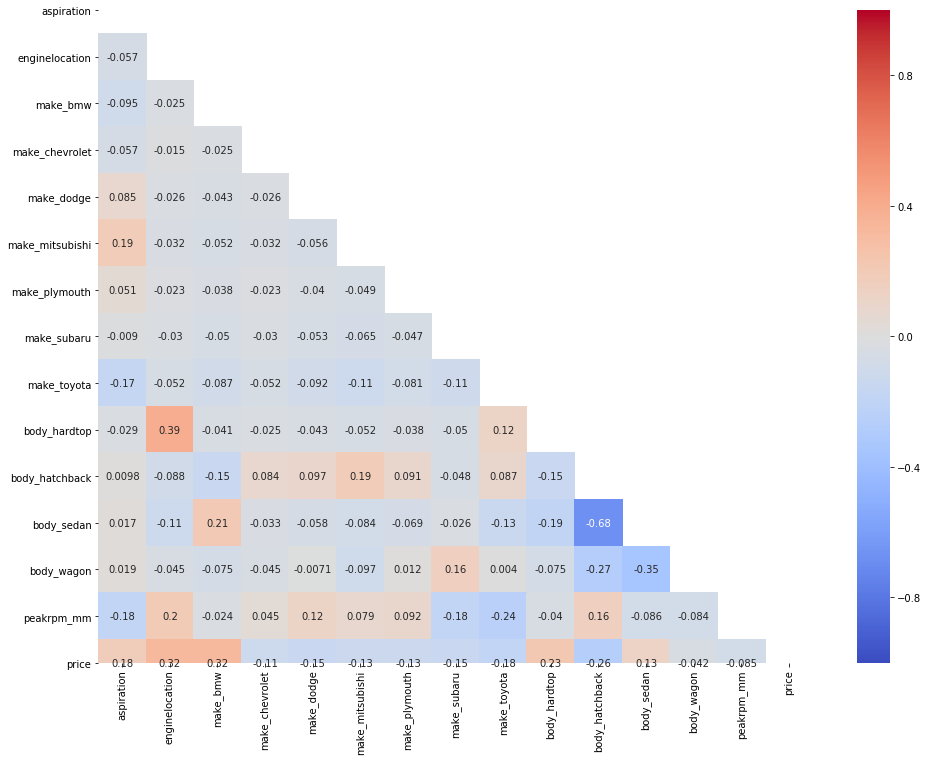

In [78]:
# carheight seems to interact less with price
# Next one
X_anova_sc3_none_comparison = pd.concat([X_anova_sc3_none,y_anova],axis=1)
heat_matrix(X_anova_sc3_none_comparison)

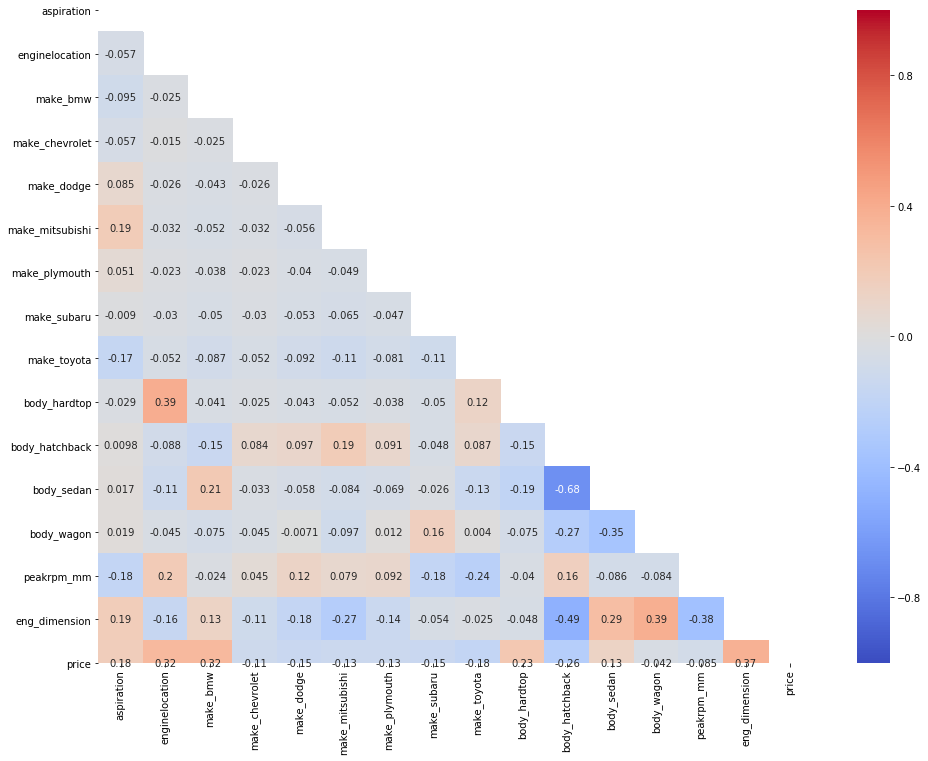

In [79]:
# And finally the one with the engineered feature
X_anova_sc3_noneEng_comparison = pd.concat([X_anova_sc3_noneEng,y_anova],axis=1)
heat_matrix(X_anova_sc3_noneEng_comparison)

Now that I have these four new data frames, I am going to run some LinearRegression on them.  
* X_anova_sc3_CH
* X_anova_sc3_WB
* X_anova_sc3_none
* X_anova_sc3_noneEng

New R^2 value for training data is:  0.6665858383286802
Test RMSE:  4792.267061749617


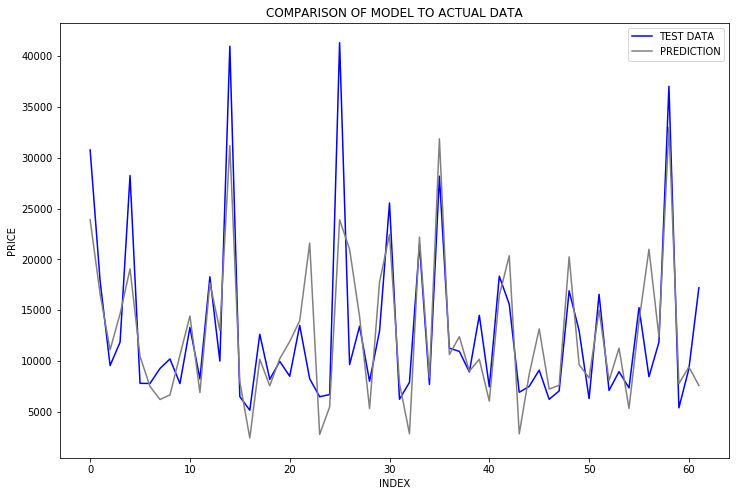

In [80]:
linreg(X_anova_sc3_CH,y_anova)

New R^2 value for training data is:  0.43560557603288064
Test RMSE:  7402.659898797566


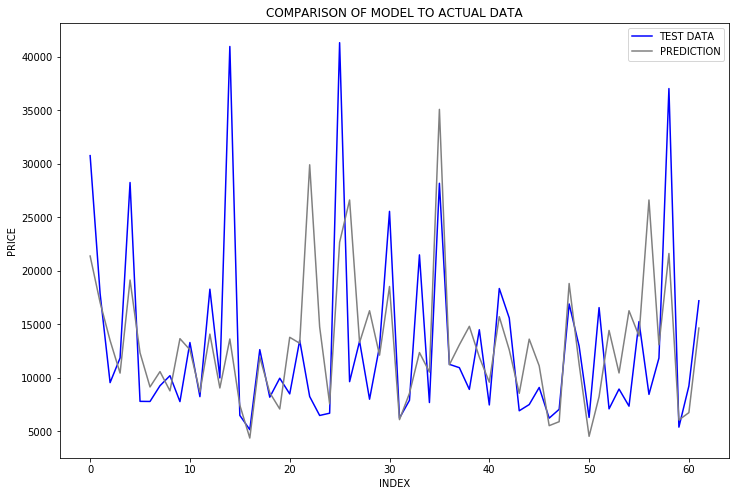

In [81]:
linreg(X_anova_sc3_WB,y_anova)

New R^2 value for training data is:  0.41747865625577085
Test RMSE:  7142.391605987334


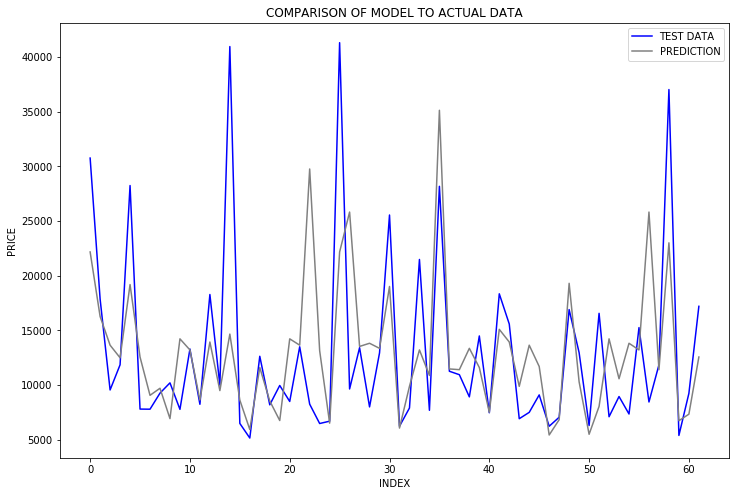

In [82]:
linreg(X_anova_sc3_none,y_anova)

New R^2 value for training data is:  0.46350700341086926
Test RMSE:  6246.486851669002


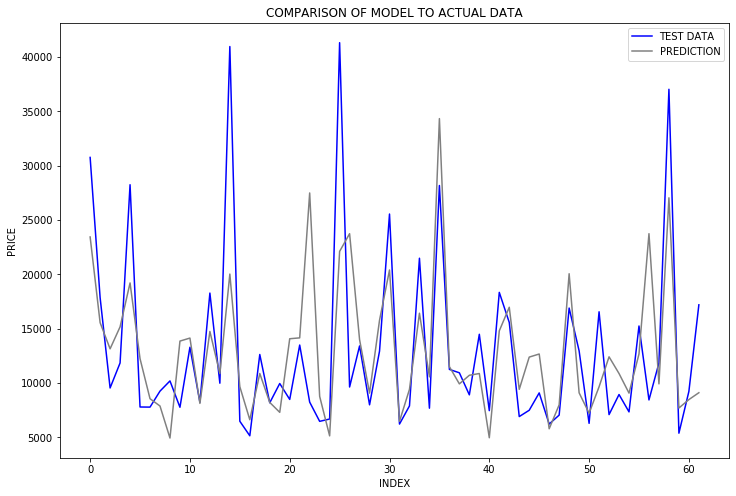

In [83]:
linreg(X_anova_sc3_noneEng,y_anova)

None of these models performed well.  
  
I will still run some cross-validation on them.

Going to run some cross_validation techniques, then enter into regularization.  
  
Going to run a cross_val on
* copy
* X_anova
* X_rfe
* X_anova_sc
* X_anova_sc2
* X_anova_sc3_CH
* X_anova_sc3_WB
* X_anova_sc3_none
* X_anova_sc3_noneEng

In [84]:
from sklearn.model_selection import cross_validate
# Going to create dictionaries for each data set

In [85]:
# Cross val on copy
original = cross_validate(lr, copy.drop(columns=['price'],axis=1), copy.price, cv=3,
              scoring=('r2','neg_mean_squared_error'), return_train_score=True)

In [86]:
# Cross val on X_anova
anova = cross_validate(lr, X_anova, y_anova, cv=3,
              scoring=('r2','neg_mean_squared_error'), return_train_score=True)

In [87]:
# Cross val on X_rfe
rfe = cross_validate(lr,X_rfe,y_rfe,cv=3,scoring=('r2','neg_mean_squared_error'),
               return_train_score=True)

In [88]:
# Cross val on X_anova_sc2
anova_sc = cross_validate(lr,X_anova_sc,y_anova,cv=3,scoring=('r2','neg_mean_squared_error'),
               return_train_score=True)

In [89]:
# Cross val on X_anova_sc2
anova_sc2 = cross_validate(lr,X_anova_sc2,y_anova,cv=3,scoring=('r2','neg_mean_squared_error'),
               return_train_score=True)

In [90]:
# Cross val on X_anova_sc3_CH
anova_sc3_CH = cross_validate(lr,X_anova_sc3_CH,y_anova,cv=3,scoring=('r2','neg_mean_squared_error'),
               return_train_score=True)
# Cross val on X_anova_sc3_WB
anova_sc3_WB = cross_validate(lr,X_anova_sc3_WB,y_anova,cv=3,scoring=('r2','neg_mean_squared_error'),
               return_train_score=True)
# Cross val on X_anova_sc3_none
anova_sc3_none = cross_validate(lr,X_anova_sc3_none,y_anova,cv=3,scoring=('r2','neg_mean_squared_error'),
               return_train_score=True)
# Cross val on X_anova_sc3_noneEng
anova_sc3_noneEng = cross_validate(lr,X_anova_sc3_noneEng,y_anova,cv=3,scoring=('r2','neg_mean_squared_error'),
               return_train_score=True)

In [91]:
# Saving the TRAIN R2 values into a data frame
train_r2 = pd.DataFrame()
train_r2['original'] = original['train_r2']
train_r2['anova'] = anova['train_r2']
train_r2['rfe'] = rfe['train_r2']
train_r2['anova_sc'] = anova_sc['train_r2']
train_r2['anova_sc2'] = anova_sc2['train_r2']
train_r2['anova_sc3_CH'] = anova_sc3_CH['train_r2']
train_r2['anova_sc3_WB'] = anova_sc3_WB['train_r2']
train_r2['anova_sc3_none'] = anova_sc3_none['train_r2']
train_r2['anova_sc3_noneEng'] = anova_sc3_noneEng['train_r2']

Text(0.5, 1.0, 'TRAIN R2 SCORE')

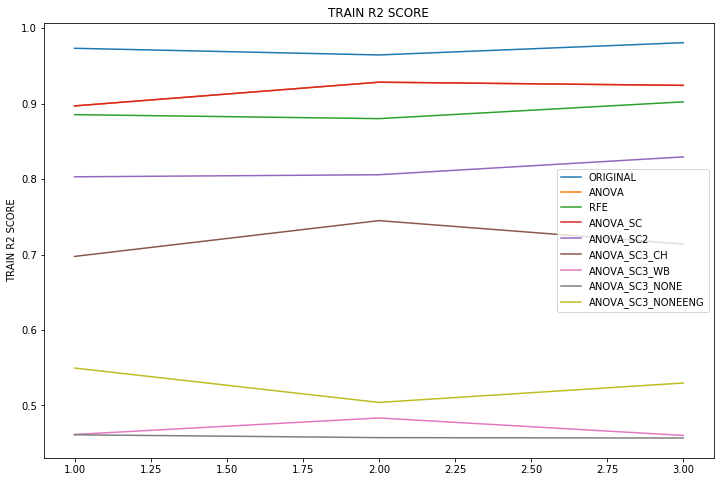

In [96]:
fig,ax=plt.subplots(figsize=(12,8))
for key in train_r2:
    sns.lineplot(x=[1,2,3],y=train_r2[key], ax=ax)
legend = list(train_r2.columns)
plt.legend(['ORIGINAL','ANOVA','RFE','ANOVA_SC','ANOVA_SC2','ANOVA_SC3_CH',
           'ANOVA_SC3_WB','ANOVA_SC3_NONE','ANOVA_SC3_NONEENG'], loc='best')
plt.ylabel('TRAIN R2 SCORE')
plt.title('TRAIN R2 SCORE')

In [98]:
# Saving the TEST R2 values into a data frame
test_r2 = pd.DataFrame()
test_r2['original'] = original['test_r2']
test_r2['anova'] = anova['test_r2']
test_r2['rfe'] = rfe['test_r2']
test_r2['anova_sc'] = anova_sc['test_r2']
test_r2['anova_sc2'] = anova_sc2['test_r2']
test_r2['anova_sc3_CH'] = anova_sc3_CH['test_r2']
test_r2['anova_sc3_WB'] = anova_sc3_WB['test_r2']
test_r2['anova_sc3_none'] = anova_sc3_none['test_r2']
test_r2['anova_sc3_noneEng'] = anova_sc3_noneEng['test_r2']

In [101]:
test_r2

,original,anova,rfe,anova_sc,anova_sc2,anova_sc3_CH,anova_sc3_WB,anova_sc3_none,anova_sc3_noneEng
0,-1.584451e+19,0.814803,0.398772,0.814803,0.650851,0.457198,-0.012655,-0.008373,0.164083
1,-2.512540e-01,0.604297,0.593489,0.605875,0.570317,0.197504,-0.123353,-0.000943,0.153464
2,-6.628996e-01,0.310044,0.328334,0.469044,0.155934,-0.149027,-1.438387,-1.348046,-0.696195


It shows here that the extra data frames I made did not perform well in cross-validation. I will thus be dropping them from my analysis.

Text(0, 0.5, 'TEST R2 SCORE')

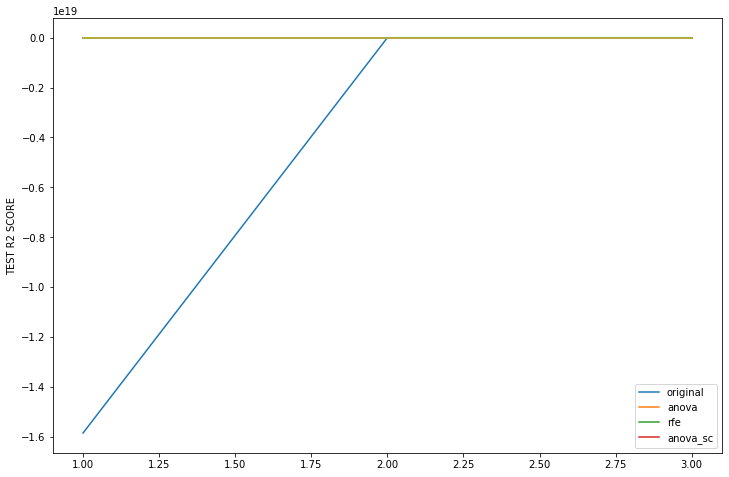

In [102]:
fig,ax=plt.subplots(figsize=(12,8))
for key in test_r2[0:4]:
    sns.lineplot(x=[1,2,3],y=test_r2[key], ax=ax) 
plt.legend([x for x in legend[0:4]], loc='best')
plt.ylabel('TEST R2 SCORE')

Going to have to drop the Original

Text(0.5, 1.0, 'TEST R2 SCORES')

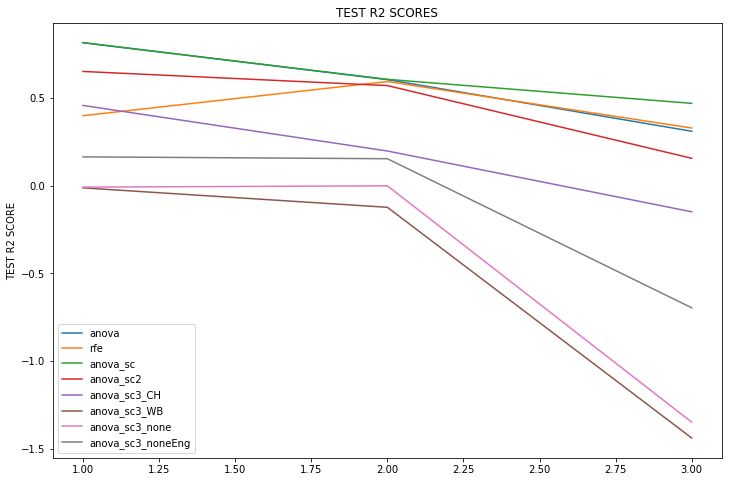

In [116]:
fig,ax=plt.subplots(figsize=(12,8))
for key in test_r2.iloc[:,1:]:
    sns.lineplot(x=[1,2,3],y=test_r2[key], ax=ax) 
plt.legend([x for x in legend[1:]], loc='best')
plt.ylabel('TEST R2 SCORE')
plt.title('TEST R2 SCORES')

Over these three validation folds, `anova_sc` did the best.

----

### Regularization
Going to try out Lasso and Ridge regularization with GridSearchCV

In [163]:
lasso = LassoCV(n_alphas=1000,cv=3,random_state=42)
ridge = RidgeCV(alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1,
                         0.3, 0.6, 1], cv=3)